In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import json

from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

plt.rcParams["figure.figsize"] = (16,8)

In [2]:
df_train = pd.read_csv('renttherunway-dataset/data/dataset_split/train.csv')
df_test = pd.read_csv('renttherunway-dataset/data/dataset_split/test.csv')

# Przebadanie pełnego zbioru

In [3]:
df_full = pd.concat([df_train, df_test])

In [4]:
df_full["full_text"] = ((f'{df_full["review_text"]} {df_full["review_summary"]} {df_full["category"]}').lower())

df_full["full_text"] = df_full["item_review_text"] = (df_full["review_text"] + 
                                                    " " + df_full["review_summary"] +
                                                    " " + df_full["category"]).astype(str).str.lower()

In [5]:
df_full.describe()

,Unnamed: 0,user_id,item_id,rating,size,age,class_rating
count,49909.000000,49909.000000,4.990900e+04,49909.000000,49909.000000,49754.000000,49909.000000
mean,24954.000000,497628.990683,1.353244e+06,4.506281,11.316536,34.940226,0.806548
std,14407.631629,290405.007448,8.260360e+05,0.736657,7.338446,8.299341,0.395008
min,0.000000,47.000000,1.233730e+05,1.000000,0.000000,2.000000,0.000000
25%,12477.000000,251221.000000,6.312510e+05,4.000000,5.000000,29.000000,1.000000
50%,24954.000000,494661.000000,1.322053e+06,5.000000,8.000000,33.000000,1.000000
75%,37431.000000,752660.000000,1.968677e+06,5.000000,16.000000,39.000000,1.000000
max,49908.000000,999910.000000,2.966087e+06,5.000000,57.000000,117.000000,1.000000


In [8]:
df_full_text_cat= df_full.groupby(
     ['item_id']
 ).agg(
     full_text = ('full_text','sum'),
 ).reset_index()


In [9]:
tfIdfVectorizer=TfidfVectorizer()
tfIdf = tfIdfVectorizer.fit_transform(df_full_text_cat['full_text'])
df_most_popular = pd.DataFrame(tfIdf[0].T.todense(), index=tfIdfVectorizer.get_feature_names(), columns=["TF-IDF"]).sort_values('TF-IDF', ascending=False)
print (df_most_popular.head(20))

           TF-IDF
the      0.506207
dress    0.291540
and      0.234301
it       0.225998
was      0.208403
slit     0.154782
to       0.140708
this     0.138370
draping  0.130419
gowni    0.129710
long     0.122584
but      0.114570
in       0.109775
for      0.105041
is       0.102904
with     0.088967
heels    0.088449
so       0.085654
of       0.085260
my       0.081800


### Problem z występującymi "stopwords"

In [10]:
tfIdfVectorizer=TfidfVectorizer(stop_words='english')
tfIdf = tfIdfVectorizer.fit_transform(df_full_text_cat['full_text'])
df_most_popular = pd.DataFrame(tfIdf[0].T.todense(), index=tfIdfVectorizer.get_feature_names(), columns=["TF-IDF"]).sort_values('TF-IDF', ascending=False)
print (df_most_popular.head(50))

                 TF-IDF
dress          0.463999
slit           0.246342
draping        0.207568
gowni          0.206438
long           0.195097
heels          0.140770
inch           0.120996
short          0.119024
black          0.108318
gownthe        0.100872
wore           0.096138
perfect        0.094520
little         0.090609
event          0.084291
bit            0.083658
wear           0.082023
sexy           0.081601
felt           0.080983
places         0.079587
length         0.078097
fit            0.077476
gown           0.075297
2r             0.072149
tie            0.070428
like           0.069243
floor          0.068640
great          0.067892
sleeves        0.067790
disappointing  0.067564
ruching        0.066266
loved          0.065577
2l             0.064907
just           0.064602
bm             0.063080
leg            0.062374
comfortable    0.062005
addams         0.061814
ordered        0.061679
gownthis       0.061605
spanx          0.061015
morticia       0

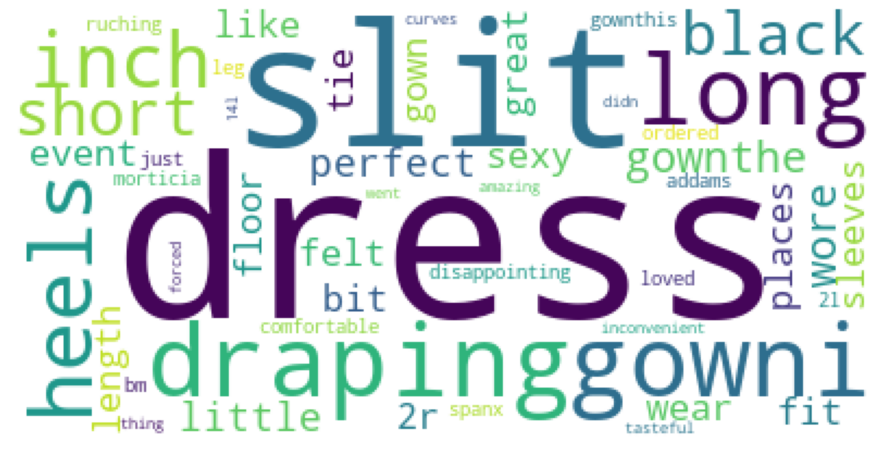

In [11]:
wordcloud = WordCloud(background_color="white", max_words=50).generate_from_frequencies(df_most_popular['TF-IDF'])
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

# Trenowanie modelu

In [12]:
df_train["full_text"] = (df_train["review_text"] + 
                         " " + df_train["review_summary"] +
                         " " + df_train["category"]).astype(str).str.lower()

In [13]:
text_agg_item= df_train.groupby(
     ['item_id']
 ).agg(
     full_text = ('full_text','sum'),
 ).reset_index()


In [14]:
text_agg_item = pd.DataFrame(df_train.groupby("item_id")["full_text"].sum())
text_agg_item

,full_text
item_id,
123373,"i love black dresses. long, short, casual, dre..."
123793,this dress has been reviewed and worn a millio...
124204,"this was my back up dress for a wedding and, f..."
124553,i wore this dress to a work even with my husba...
125424,this was a wonderful dress. i usually don't we...
...,...
2963344,"great fit, comfortable, different color that g..."
2963850,loved this skirt! print is unique and length w...
2964470,i loved this sweater from tory burch. i didn't...


In [21]:
tfIdfVectorizer_stopwords = TfidfVectorizer(stop_words='english')
tfIdf = tfIdfVectorizer_stopwords.fit_transform(text_agg_item["full_text"])
tfIdf[1]

<1x19306 sparse matrix of type '<class 'numpy.float64'>'
	with 890 stored elements in Compressed Sparse Row format>

In [15]:
tfIdfVectorizer_stopwords = TfidfVectorizer(stop_words='english')
tfIdf = tfIdfVectorizer_stopwords.fit_transform(text_agg_item["full_text"])
tfidf_similarity = cosine_similarity(tfIdf, tfIdf)
tfidf_similarity_df = pd.DataFrame(tfidf_similarity,
                                   columns=text_agg_item.index,
                                   index=text_agg_item.index)

tfidf_similarity_df.head()

item_id,123373,123793,124204,124553,125424,125465,125564,126335,127081,127495,...,2959486,2960025,2960940,2960969,2962646,2963344,2963850,2964470,2965009,2966087
item_id,,,,,,,,,,,,,,,,,,,,,
123373,1.000000,0.636957,0.451958,0.520706,0.484200,0.569328,0.572645,0.514432,0.409091,0.506000,...,0.140021,0.080588,0.034626,0.169292,0.079734,0.077768,0.140932,0.063310,0.052503,0.182796
123793,0.636957,1.000000,0.614557,0.560300,0.529526,0.647962,0.624262,0.708029,0.468717,0.508815,...,0.138300,0.112080,0.055459,0.151972,0.060878,0.067053,0.141019,0.059687,0.067607,0.175472
124204,0.451958,0.614557,1.000000,0.588896,0.545858,0.453714,0.402660,0.743998,0.318101,0.555078,...,0.146273,0.075467,0.054926,0.141399,0.084179,0.087755,0.135613,0.083059,0.073292,0.125553
124553,0.520706,0.560300,0.588896,1.000000,0.706743,0.598038,0.481823,0.665416,0.377788,0.616875,...,0.167106,0.099131,0.062982,0.217719,0.136849,0.138257,0.194768,0.093027,0.062336,0.149736
125424,0.484200,0.529526,0.545858,0.706743,1.000000,0.485630,0.454304,0.632764,0.364412,0.568717,...,0.171479,0.090394,0.069032,0.236074,0.112394,0.105609,0.179542,0.091871,0.069654,0.149242


In [16]:
def make_recommendation(target_user_id,tfidf_sim_df , top_n = 20):
    top_item_id = int(df_train[df_train.user_id == target_user_id].head(1).item_id)
    df_similarity = tfidf_sim_df[[top_item_id]].sort_values([top_item_id], ascending=False)
    df_similarity = df_similarity.iloc[1:]
    df_similarity = df_similarity[top_item_id] 
    return df_similarity.head(top_n)

In [17]:
make_recommendation(345809, tfidf_similarity_df )

item_id
1676837    0.624232
1962198    0.531422
174086     0.523560
1005880    0.521265
136110     0.514599
197170     0.514224
1076484    0.511246
1737394    0.508837
435001     0.508453
478077     0.501705
657626     0.500662
1800440    0.500466
1048184    0.497327
172027     0.496385
1092231    0.495806
858304     0.493612
126335     0.488969
532135     0.487958
1179273    0.487787
921642     0.487012
Name: 326784, dtype: float64

# Test

In [19]:
test_results = {}

for user_id in df_test['user_id'].values:
    items_similarities = make_recommendation(user_id, tfidf_similarity_df, top_n = 100)
    item_sim = {}
    for item_id, sim in items_similarities.items():
        item_sim[str(item_id)] = float(sim)
    test_results[str(user_id)] = item_sim

with open('tfidf_results_top_100.json', 'w') as outfile:
    json.dump(test_results, outfile)